# 簡介

基於transformers的語言模型在許多不同的自然語言處理(NLP)基準任務測試上都取得了很大進展。遷移學習與大規模的transformers語言模型訓練的結合正在成為現代NLP的一個標準。在這篇文章,我們對transformers體系結構和文本分類問題做一些必要的理論介紹。然後，我們將演示預訓練BERT模型在文本分類任務的微調過程，這裡運用的是TensorFlow 2.0+的Keras API。

# 文本分類--問題及公式
一般來說, 分類是確定新樣本的類別問題。  
我們有數據集D，在文檔中包含文本序列，Xi是每一段文本而N是文本的個數。

實現分類的算法稱為分類器。文本分類可以根據目標性質分為不同的任務：

* 多分類問題(multi-class classification)
* 多標籤問題(multi-label classification)

多分類也稱為單標籤問題，例如，我們為每個樣本分配一個標籤。名稱中的"多"表示我們處理至少3 個類，對於2 個類，我們可以使用術語二進制分類(binary classification)。另一方面，多標籤任務更為一般，允許我們為每個樣本分配多個標籤，而不僅僅是一樣本一標籤。

# 基於RNNs/LSTMs 的方法
大多數較舊的語言建模方法都基於RNN（recurrent neural network）。簡單的RNN 存在梯度消失/梯度爆炸問題，所以無法對較長的上下文依賴關係進行建模。它們大多數被所謂的長短期記憶網絡模型（LSTMs） 所取代, 該神經網絡也是RNN 的一個變種形式，但可以捕獲文檔中較長的上下文。然而，LSTM 只能單向處理序列，因此基於LSTM 的最先進方法演變為雙向LSTM，此結構可以從左到右以及從右到左讀取上下文。基於LSTM有非常成功的模型，如ELMO或ULMFIT，這些模型仍然適用於現在的NLP任務。

# 基於transformers架構的方法
雙向LSTM 的主要限制之一是其順序性，這使得併行訓練非常困難, transformer 架構通過注意力機制(Vashvani et al. 2017) 完全取代LSTM來解決這一個問題。在註意力機制中，我們把整個序列看作一個整體, 因此並行訓練要容易得多。我們可以對整個文檔上下文進行建模，並使用大型數據集以無人監督學習的方式進行預訓練，並微調下游任務。

# BERT
BERT (Bidirectional Encoder Representations from Transformers) (Devlint et al., 2018) 是一種預訓練語言表示的方法。我們不會討論太多細節，但與原始transformers (Vaswani et al., 2017) 的主要區別是, BERT沒有解碼器, 但在基本版本中堆疊了12個編碼器，而且在更大的預訓練模型中會增加編碼器的數量。這種架構不同於OpenAI 的GPT-2，它是適合自然語言生成（NLG） 的自回歸語言模型。



# Tokenizer
官方BERT 語言模型是使用切片詞彙預訓練與使用, 不僅token 嵌入, 而且有區分成對序列的段嵌入, 例如問答系統。由於注意力機制在上下文評估中不考慮位置，因此需要把位置信息嵌入才能將位置感知注入BERT 模型。

需要注意的是，BERT限制序列的最大長度, 可能是128，256，512，768(根據下載的BERT模型大小)。對於比最大允許輸入短的序列，我們需要添加[PAD]，另一方面，如果序列更長，我們需要剪切序列。對於較長的文本段，您需要了解此對序列最大長度的BERT 限制，請參閱此GitHub issue以了解進一步的解決方案(https://github.com/huggingface/transformers/issues/2295) 。

非常重要的還有所謂的特殊token，例如[CLS] token和[SEP] token。[CLS] token將插入序列的開頭，[SEP] token位於末尾。如果我們處理序列對，我們將在最後一個序列對的末尾添加額外的[SEP] token。

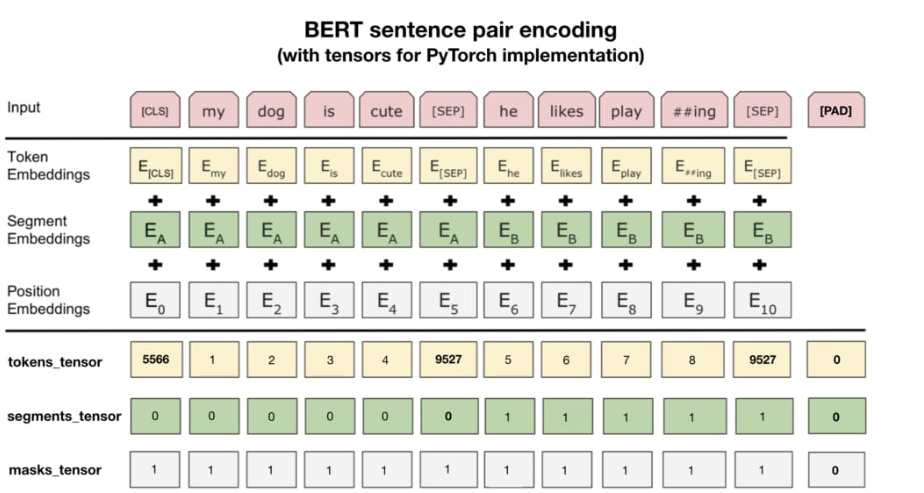

In [1]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese',do_basic_tokenize=False)
max_length_test = 20
test_sentence = '狐狸被陌生人拍照'

print('sentence :',test_sentence)

# add special tokens
test_sentence_with_special_tokens = '[CLS]' + test_sentence + '[SEP]'
tokenized = tokenizer.tokenize(test_sentence_with_special_tokens)
print('tokenized :', tokenized)

# convert tokens to ids in WordPiece
input_ids = tokenizer.convert_tokens_to_ids(tokenized)

# precalculation of pad length, so that we can reuse it later on
padding_length = max_length_test - len(input_ids)

# map tokens to WordPiece dictionary and add pad token for those text shorter than our max length
input_ids = input_ids + ([0] * padding_length)

# attention should focus just on sequence with non padded tokens
attention_mask = [1] * len(input_ids)

# do not focus attention on padded tokens
attention_mask = attention_mask + ([0] * padding_length)

# token types, needed for example for question answering, for our purpose we will just set 0 as we have just one sequence
token_type_ids = [0] * max_length_test
bert_input = {
    "token_ids": input_ids,
    "token_type_ids": token_type_ids,
    "attention_mask": attention_mask
} 
for key in bert_input:
    print(key, ':', bert_input[key]) 


sentence : 狐狸被陌生人拍照
tokenized : ['[CLS]', '狐', '##狸', '##被', '##陌', '##生', '##人', '##拍', '##照', '[SEP]']
token_ids : [101, 4316, 17386, 19215, 20416, 17552, 13839, 15921, 17269, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [2]:
test_sentence = '狐狸被陌生人拍照'
max_length_test = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese',do_basic_tokenize=False)
bert_input = tokenizer.encode_plus(
        test_sentence,   
        add_special_tokens = True,    # add [CLS], [SEP]
        truncation=True,              # truncation（截斷）
        max_length = max_length_test, # max length of the text that can go to BERT
        padding='max_length',         # add [PAD] tokens
        return_attention_mask = True, # add attention mask to not focus on pad tokens
      )
print('encoded', bert_input)

encoded {'input_ids': [101, 4316, 17386, 19215, 20416, 17552, 13839, 15921, 17269, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


# 預訓練
預訓練是BERT訓練的第一階段，它以無監督的方式完成，由兩個主要任務組成：

* masked language modelling (MLM)
* next sentence prediction (NSP)

# 微調（Fine-tuning）
一旦我們自己預訓練了模型，或者加載了已預訓練過的模型（例如BERT-based-uncased、BERT-based-chinese）,我們就可以開始對下游任務（如問題解答或文本分類）的模型進行微調。我們可以看到，BERT 可以將預訓練的BERT 表示層嵌入到許多特定任務中，對於文本分類，我們將只在頂部添加簡單的softmax 分類器。

In [11]:
# 讀取新聞資料集
import pandas as pd
df_raw = pd.read_csv("data_10000.txt",sep="\t",header=None,names=["text","label"])
df_raw

,text,label
0,中華女子學院：本科層次僅1專業招男生,教育
1,兩天價網站背後重重迷霧：做個網站究竟要多少錢,科技
2,東5環海棠公社230-290平2居準現房98折優惠,房產
3,卡佩羅：告訴你德國腳生猛的原因 不希望英德戰踢點球,體育
4,82歲老太為學生做飯掃地44年獲授港大榮譽院士,社會
...,...,...
9995,到底看哪個 E3展世界杯場次時間衝突,遊戲
9996,女環衛工母親節被撞飛身亡 肇事司機疑疲勞駕駛,社會
9997,手游《烙印》GM美眉陪您國慶長假,遊戲
9998,趣味測試：考場上你會怯場嗎(圖),教育


In [12]:
notnull_df = df_raw.notnull()
# 篩選出非空值
notnull_mask = notnull_df.all(axis=1)
df_raw = df_raw[notnull_mask]
df_raw

,text,label
0,中華女子學院：本科層次僅1專業招男生,教育
1,兩天價網站背後重重迷霧：做個網站究竟要多少錢,科技
2,東5環海棠公社230-290平2居準現房98折優惠,房產
3,卡佩羅：告訴你德國腳生猛的原因 不希望英德戰踢點球,體育
4,82歲老太為學生做飯掃地44年獲授港大榮譽院士,社會
...,...,...
9995,到底看哪個 E3展世界杯場次時間衝突,遊戲
9996,女環衛工母親節被撞飛身亡 肇事司機疑疲勞駕駛,社會
9997,手游《烙印》GM美眉陪您國慶長假,遊戲
9998,趣味測試：考場上你會怯場嗎(圖),教育


In [13]:
for i, data in enumerate(notnull_df.iloc()):
    if (data.text == False) or (data.label == False):
        print(i)
        print(data)

3881
text      True
label    False
Name: 3881, dtype: bool


In [14]:
max_len = 0
for i, data in enumerate(df_raw.iloc()):
    if len(data.text)>max_len:
        max_len = len(data.text)
print("max_len:",max_len)

max_len: 32


In [15]:
# 建立標籤轉換
label = ["財經","房產","股票","教育","科技","社會","時政","體育","遊戲","娛樂"]
y = list(range(len(label)))
label_dict = {"label":label,"y":y}
df_label = pd.DataFrame(label_dict)
df_label

,label,y
0,財經,0
1,房產,1
2,股票,2
3,教育,3
4,科技,4
5,社會,5
6,時政,6
7,體育,7
8,遊戲,8
9,娛樂,9


In [16]:
# pd.merge 合併資料框（DataFrame）: 
    # how 是合併方式，可以是 'inner'（內部合併）、'outer'（外部合併）、'left'（左邊合併）或 'right'（右邊合併）
    # on 是要合併的共同欄位
df_raw = pd.merge(df_raw, df_label, how='left', on='label')
df_raw

,text,label,y
0,中華女子學院：本科層次僅1專業招男生,教育,3
1,兩天價網站背後重重迷霧：做個網站究竟要多少錢,科技,4
2,東5環海棠公社230-290平2居準現房98折優惠,房產,1
3,卡佩羅：告訴你德國腳生猛的原因 不希望英德戰踢點球,體育,7
4,82歲老太為學生做飯掃地44年獲授港大榮譽院士,社會,5
...,...,...,...
9994,到底看哪個 E3展世界杯場次時間衝突,遊戲,8
9995,女環衛工母親節被撞飛身亡 肇事司機疑疲勞駕駛,社會,5
9996,手游《烙印》GM美眉陪您國慶長假,遊戲,8
9997,趣味測試：考場上你會怯場嗎(圖),教育,3


In [17]:
# 讀取 DataFram 的方式: .loc[index, '標題']
df_raw.loc[0, 'text']

'中華女子學院：本科層次僅1專業招男生'

In [18]:
# 將新聞進行段詞處理!
import jieba
jieba.set_dictionary('dict.txt.big.txt')

for i in range(len(df_raw)):
    text = df_raw.loc[i,'text']             # 讀取每一篇新聞的標題 "text"
    words = jieba.lcut(text)                # 透過 jieba 斷詞
    df_raw.loc[i,'text'] = ' '.join(words)  # 將斷詞後的結果用" "串接更新回去
    #print(df_raw.loc[i,'text'])

Building prefix dict from C:\Users\Landis\Desktop\NLP\dict.txt.big.txt ...
Loading model from cache C:\Users\Landis\AppData\Local\Temp\jieba.ud6a07bc9c9532c719ef6358f90113c5d.cache
Loading model cost 0.789 seconds.
Prefix dict has been built successfully.


In [19]:
df_raw

,text,label,y
0,中華 女子 學院 ： 本科 層次 僅 1 專業 招 男生,教育,3
1,兩天 價 網站 背後 重重 迷霧 ： 做個 網站 究竟 要 多少錢,科技,4
2,東 5 環 海棠 公社 230 - 290 平 2 居 準現房 98 折 優惠,房產,1
3,卡佩羅 ： 告訴 你 德國 腳 生猛 的 原因 不 希望 英德 戰 踢 點球,體育,7
4,82 歲 老太 為 學生 做飯 掃地 44 年 獲授 港大 榮譽 院士,社會,5
...,...,...,...
9994,到底 看 哪個 E3 展 世界杯 場次 時間 衝突,遊戲,8
9995,女 環衛工 母親節 被 撞 飛 身亡 肇事 司機 疑 疲勞 駕駛,社會,5
9996,手游 《 烙印 》 GM 美眉 陪您 國慶 長假,遊戲,8
9997,趣味 測試 ： 考場 上 你 會 怯場 嗎 ( 圖 ),教育,3


In [20]:
# 將資料分割成 訓練集、驗證集、測試集
from sklearn.model_selection import train_test_split
import pandas as pd

def split_dataset(df):
    # stratify 為根據 'label' 欄位的值進行分割抽樣。可以確保訓練集和測試集中的 'label'欄位的分佈相同
    # 設置了 random_state 為 42，以確保每次運行時都能得到相同的分割結果。
    train_set, x = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)
    val_set, test_set = train_test_split(x, stratify=x['label'], test_size=0.5, random_state=43)
    return train_set,val_set, test_set

train_data,val_data, test_data = split_dataset(df_raw)

In [21]:
print("訓練集的數量：%s" %len(train_data))
print("測試集的數量：%s" %len(test_data))
print("驗證集的數量：%s" %len(val_data))

訓練集的數量：7999
測試集的數量：1000
驗證集的數量：1000


In [22]:
from collections import Counter
print("訓練集的類別數量：%s" %Counter(train_data.label))
print("測試集的類別數量：%s" %Counter(test_data.label))
print("驗證集的類別數量：%s" %Counter(val_data.label))

訓練集的類別數量：Counter({'遊戲': 835, '房產': 823, '娛樂': 809, '時政': 809, '股票': 806, '財經': 801, '科技': 792, '體育': 792, '社會': 774, '教育': 758})
測試集的類別數量：Counter({'遊戲': 105, '房產': 103, '時政': 102, '娛樂': 101, '股票': 100, '財經': 100, '體育': 99, '科技': 99, '社會': 96, '教育': 95})
驗證集的類別數量：Counter({'遊戲': 104, '房產': 103, '股票': 101, '時政': 101, '娛樂': 101, '財經': 100, '體育': 99, '科技': 99, '社會': 97, '教育': 95})


In [23]:
import tensorflow as tf
from transformers import BertTokenizer

def convert_example_to_feature(review):
    return tokenizer.encode_plus(review, 
             add_special_tokens = True,    # add [CLS], [SEP]
             truncation=True,  
             max_length = max_length_test, # max length of the text that can go to BERT
             padding='max_length',         # add [PAD] tokens
             return_attention_mask = True, # add attention mask to not focus on pad tokens
            )

# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)

    for index, row in ds.iterrows():
        review = row["text"]
        label = row["y"]
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [24]:
max_length_test = 32
batch_size = 64

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese',do_basic_tokenize=False)

# 將訓練資料製作成 Dataset:
ds_train_encoded = encode_examples(train_data).shuffle(10000).batch(batch_size)
ds_val_encoded = encode_examples(val_data).batch(batch_size)
ds_test_encoded = encode_examples(test_data).batch(batch_size)

In [25]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=10)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  102267648 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 102,275,338
Trainable params: 102,275,338
Non-trainable params: 0
_________________________________________________________________


In [26]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 8

# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=10)

# optimizer Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-08, clipnorm=1)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# fit model
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_val_encoded)
# evaluate test set
model.evaluate(ds_test_encoded)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
125/125 [==============================] - 38s 205ms/step - loss: 1.3647 - accuracy: 0.5773 - val_loss: 0.7866 - val_accuracy: 0.7530
Epoch 2/8
125/125 [==============================] - 24s 193ms/step - loss: 0.6413 - accuracy: 0.8077 - val_loss: 0.5731 - val_accuracy: 0.8240
Epoch 3/8
125/125 [==============================] - 24s 193ms/step - loss: 0.4421 - accuracy: 0.8670 - val_loss: 0.5608 - val_accuracy: 0.8350
Epoch 4/8
125/125 [==============================] - 24s 192ms/step - loss: 0.2889 - accuracy: 0.9160 - val_loss: 0.5919 - val_accuracy: 0.8260
Epoch 5/8
125/125 [==============================] - 24s 194ms/step - loss: 0.1914 - accuracy: 0.9457 - val_loss: 0.5753 - val_accuracy: 0.8430
Epoch 6/8
125/125 [==============================] - 24s 194ms/step - loss: 0.1308 - accuracy: 0.9644 - val_loss: 0.6236 - val_accuracy: 0.8440
Epoch 7/8
125/125 [==============================] - 24s 193ms/step - loss: 0.0844 - accuracy: 0.9766 - val_loss: 0.6694 - val_accuracy:

[0.772371768951416, 0.8240000009536743]

# 資料集未經過斷詞處理

In [3]:
import tensorflow as tf
from transformers import BertTokenizer

def convert_example_to_feature(review):
    return tokenizer.encode_plus(review, 
             add_special_tokens = True,    # add [CLS], [SEP]
             truncation=True,  
             max_length = max_length_test, # max length of the text that can go to BERT
             padding='max_length',         # add [PAD] tokens
             return_attention_mask = True, # add attention mask to not focus on pad tokens
            )

# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)

    for index, row in ds.iterrows():
        review = row["text"]
        label = row["y"]
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [4]:
import pandas as pd
# 讀取新聞資料集
df_raw = pd.read_csv("data_10000.txt",sep="\t",header=None,names=["text","label"])

# 篩選出非空值
notnull_df = df_raw.notnull()
notnull_mask = notnull_df.all(axis=1)
df_raw = df_raw[notnull_mask]

# 建立標籤轉換
label = ["財經","房產","股票","教育","科技","社會","時政","體育","遊戲","娛樂"]
y = list(range(len(label)))
label_dict = {"label":label,"y":y}
df_label = pd.DataFrame(label_dict)
df_raw = pd.merge(df_raw, df_label, how='left', on='label')

# 將資料分割成 訓練集、驗證集、測試集
from sklearn.model_selection import train_test_split
import pandas as pd
def split_dataset(df):
    train_set, x = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)
    val_set, test_set = train_test_split(x, stratify=x['label'], test_size=0.5, random_state=43)
    return train_set,val_set, test_set
train_data,val_data, test_data = split_dataset(df_raw)

max_length_test = 32
batch_size = 64
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese',do_basic_tokenize=True)
ds_train_encoded = encode_examples(train_data).shuffle(10000).batch(batch_size)
ds_val_encoded = encode_examples(val_data).batch(batch_size)
ds_test_encoded = encode_examples(test_data).batch(batch_size)

from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=10)

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 8

# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=10)

# optimizer Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-08, clipnorm=1)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# 可視化訓練過程
tensorboard = TensorBoard(log_dir="my_log")

# 模型檢查點
# 使用 ModelCheckpoint 來幫助我們監控指標:
    # filepath：保存模型權重的文件路徑。
    # monitor：要監控的指標，例如 val_loss 或 val_accuracy。
    # save_best_only：當監控指標有提升時才保存模型。
    # save_weights_only:只保存模型的權重，在訓練下游bert模型時使用。
    # verbose：輸出信息的詳細程度。
model_checkpoint = ModelCheckpoint(filepath="weight.{epoch:02d}-{val_accuracy:.4f}.h5", 
                        monitor="val_accuracy", save_best_only=True, save_weights_only=True, verbose=0)

# fit model
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs,
                validation_data=ds_val_encoded, callbacks=[tensorboard, model_checkpoint])

# evaluate test set
model.evaluate(ds_test_encoded)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
125/125 [==============================] - 41s 207ms/step - loss: 0.9188 - accuracy: 0.7651 - val_loss: 0.4190 - val_accuracy: 0.8900
Epoch 2/8
125/125 [==============================] - 25s 196ms/step - loss: 0.3184 - accuracy: 0.9152 - val_loss: 0.3304 - val_accuracy: 0.9050
Epoch 3/8
125/125 [==============================] - 24s 194ms/step - loss: 0.1920 - accuracy: 0.9489 - val_loss: 0.3562 - val_accuracy: 0.9060
Epoch 4/8
125/125 [==============================] - 24s 190ms/step - loss: 0.1232 - accuracy: 0.9675 - val_loss: 0.3681 - val_accuracy: 0.9060
Epoch 5/8
125/125 [==============================] - 24s 192ms/step - loss: 0.0858 - accuracy: 0.9780 - val_loss: 0.3942 - val_accuracy: 0.9080
Epoch 6/8
125/125 [==============================] - 24s 194ms/step - loss: 0.0575 - accuracy: 0.9867 - val_loss: 0.3823 - val_accuracy: 0.9090
Epoch 7/8
125/125 [==============================] - 24s 192ms/step - loss: 0.0414 - accuracy: 0.9899 - val_loss: 0.4235 - val_accuracy:

[0.439115047454834, 0.906000018119812]

In [9]:
%reload_ext tensorboard

In [10]:
%load_ext tensorboard
%tensorboard --logdir=my_log

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 63040), started 1:35:58 ago. (Use '!kill 63040' to kill it.)

In [ ]:
model.save_pretrained("bert_class_model")

In [27]:
from transformers import BertForSequenceClassification
from tensorflow.nn import softmax
import numpy as np
model_use = TFBertForSequenceClassification.from_pretrained("bert_class_model")
output = model_use({'input_ids':np.expand_dims(np.array(bert_input['input_ids']),axis=0),'attention_mask':np.expand_dims(np.array(bert_input['attention_mask']),axis=0)})
np.argmax(softmax(output.logits))
# for inputs in ds_test_encoded:
#     output = model_use(inputs) 
#     for output in output.logits:
#         print(np.argmax(softmax(output)))
#     break

OSError: Error no file named tf_model.h5 found in directory bert_class_model but there is a file for PyTorch weights. Use `from_pt=True` to load this model from those weights.

In [ ]:
test_data

In [ ]:
ds_test_encoded

In [ ]:
len(ds_test_encoded)

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer

def convert_example_to_feature(review):
    return tokenizer.encode_plus(review, 
             add_special_tokens = True,    # add [CLS], [SEP]
             truncation=True,  
             max_length = max_length_test, # max length of the text that can go to BERT
             padding='max_length',         # add [PAD] tokens
             return_attention_mask = True, # add attention mask to not focus on pad tokens
            )

# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }

def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)

    for index, row in ds.iterrows():
        review = row["text"]
        label = row["y"]
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list)).map(map_example_to_dict)

In [ ]:
ds_test_encoded = encode_examples(test_data).batch(batch_size, drop_remainder=True)
print(ds_test_encoded)

In [ ]:
test_sentence = 'MLB》大谷翔平孤立無援 天使球迷不滿神鱒、阮棟缺陣'
max_length_test = 32
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese',do_basic_tokenize=True)
bert_input = tokenizer.encode_plus(
        test_sentence,   
        add_special_tokens = True,    # add [CLS], [SEP]
        truncation=True,              # truncation（截斷）
        max_length = max_length_test, # max length of the text that can go to BERT
        padding='max_length',         # add [PAD] tokens
        return_attention_mask = True, # add attention mask to not focus on pad tokens
      )
print('encoded', bert_input)

In [ ]:
model_use({'input_ids':np.expand_dims(np.array(bert_input['input_ids']),axis=0),'attention_mask':np.expand_dims(np.array(bert_input['attention_mask']),axis=0)})

In [ ]:
test_aaa = 'NBA季後賽》誇張！被沙波尼斯抓腳 格林竟狠踩他肚子'
d = {'text':[test_aaa],'label':[None],'y':[None]}
df = pd.DataFrame(d)
a = encode_examples(df).batch(35)
for i in a:
    c = model_use(i)
    print(label[np.argmax(c.logits)])